In [78]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os

In [4]:
def shuffle_with_seed(arr, seed):
    #shuffle the rows of the matrix
    np.random.seed(seed)
    np.random.shuffle(arr)
    return arr

In [5]:
data = pd.read_csv('train.csv')
data = np.array(data)
M,N = data.shape
data = shuffle_with_seed(data,42)

In [6]:
M,N

(42000, 785)

In [10]:
#manual train-test split
data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:N]
X_test = X_test/255
#normalize the X value so that it deos not blow up in the exponential calculations.

data_train = data[1000:M].T
Y_train = data_train[0]
X_train = data_train[1:N]
X_train = X_train/255

N_train,M_train = X_train.shape
N0 = N_train
N1 = 10
N2 = 10
M = M_train

In [8]:
N_train,M_train

(784, 41000)

In [12]:

X_train.shape

(784, 41000)

In [13]:
Y_train

array([2, 6, 4, ..., 2, 6, 0], dtype=int64)

In [69]:

def initialize_para(seed=None):
    # pass the random seed for reproducibility
    W1 = generate_random_matrix(N1,N0,seed)
    W2 = generate_random_matrix(N2,N1,seed)
    b1 = generate_random_matrix(N1,1,seed)
    b2 = generate_random_matrix(N2,1,seed)

    W = [W1,W2]
    b = [b1,b2]
    
    return W, b


def generate_random_matrix(N, M, seed=None):
    # Set the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    # Generate an N x M matrix with values uniformly distributed between 0 and 1
    random_matrix = np.random.rand(N, M)
    # Scale and shift the values to the range [-0.5, 0.5]
    random_matrix = 1 * random_matrix - 0.5
    return random_matrix

def forward_propagation(W,b,X):
    b1, b2 = b
    W1, W2 = W
    Z1 = W1.dot(X)+b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1)+b2
    #Z2 = Z2- np.max(Z2, axis=0, keepdims=True)
    A2 = softmax(Z2)

    Z = [Z1,Z2]
    A = [A1,A2]

    return Z,A


def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Subtract max for numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def ReLU(Z):
    return np.maximum(0,Z)

def ReLU_derivative(Z):
    return Z>0

#pack A1,A2 into tuples(can also use lists)
#A = (A1,A2)

#calculation of gradient terms
def back_propagation(A,Z,W,X,Y):
    #A0 = X #size N0 x M
    A1, A2 = A
    Z1, Z2 = Z
    W1, W2 = W
    #N,M = X.shape
    # apply one hot encoding to Y
    one_hot_Y = one_hot(Y)
    #calculate the approximate form for partial L partial Z2
    pd_Z2_L = (A2-one_hot_Y)/M #size N2 x M
    #calculate the approximate form for partial L partial Z1
    pd_Z1_L = W2.T.dot(pd_Z2_L)*ReLU_derivative(Z1) # size N1 x M

    # now the derivative that directly affect gradient updates
    pd_W2_L = pd_Z2_L.dot(A1.T) #size N2 x M
    pd_b2_L = np.sum(pd_Z2_L, axis = 1, keepdims=True) #size N2 x 1

    pd_W1_L = pd_Z1_L.dot(X.T) #size N1 x M
    pd_b1_L = np.sum(pd_Z1_L, axis=1, keepdims=True) # size N1 x 1

    pd_W = [pd_W1_L, pd_W2_L]
    pd_b = [pd_b1_L, pd_b2_L]
    return pd_W, pd_b

# def update_weights(W,b,pd_W,pd_b,alpha):
#     W1,W2 = W
#     b1,b2 = b

#     pd_W1,pd_W2 = pd_W
#     pd_b1,pd_b2 = pd_b

#     W1 = W1-alpha*pd_W1
#     W2 = W2-alpha*pd_W2

#     b1 = b1- alpha*pd_b1
#     b2 = b2- alpha*pd_b2

#     W = (W1,W2)
#     b = (b1,b2)

#     return W,b

#simplified version
def update_weights(W, b, pd_W, pd_b, alpha):
    W = list(w - alpha * pd_w for w, pd_w in zip(W, pd_W))
    b = list(bi - alpha * pd_bi for bi, pd_bi in zip(b, pd_b))
    return W, b

#one hot encoding
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def gradient_descent(X,Y,alpha,iter,seed=None,W=None,b=None):
    if W is None and b is None:
        W, b = initialize_para(seed)

    i=0
    while i < iter:
        Z,A = forward_propagation(W,b,X)
        pd_W, pd_b = back_propagation(A,Z,W,X,Y)
        W,b = update_weights(W,b,pd_W,pd_b,alpha)
        i = i+1
        if (i%10 ==0 and i<=50) or i%100 ==0:
            print("iteration: %d\n" %i)
            pred_Y = get_pred(A)
            accuracy = get_accuracy(Y,pred_Y)
            print('%s || %s\naccuracy = %.6f' % (pred_Y, Y, accuracy))
    return W,b

def get_pred(A):
    _,A2 = A
    # Use np.argmax along axis 0 to get the indices of the maximum values in each column
    max_indices = np.argmax(A2, axis=0)
    return max_indices

def get_accuracy(Y,pred_Y):
    return np.sum(Y==pred_Y, axis=0)/len(Y)


def get_new_pred(X,W,b):
    _,A = forward_propagation(W,b,X)
    Y_pred = get_pred(A)
    return Y_pred

def show_pred(idx_sample,X,Y, W,b):
    current_sample_X = X[:, idx_sample,None] # the None keeps the structure of the slicing, i.e. keeps the result as a column vector
    current_sample_Y = Y[idx_sample]
    current_pred_Y = get_new_pred(current_sample_X,W,b)
    print('prediction:',current_pred_Y)
    print('lable:',current_sample_Y)

    X_mat = current_sample_X.reshape((28, 28)) * 255
    #plt.figure(figsize=(5, 5))
    plt.imshow(X_mat, cmap='gray')
    plt.show()


In [72]:
W,b = gradient_descent(X_train,Y_train,0.1,1000,42,None,None)

iteration: 10

[3 3 0 ... 1 0 8] || [2 6 4 ... 2 6 0]
accuracy = 0.206415
iteration: 20

[3 3 0 ... 9 0 0] || [2 6 4 ... 2 6 0]
accuracy = 0.277805
iteration: 30

[3 3 0 ... 9 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.340146
iteration: 40

[3 3 4 ... 8 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.389683
iteration: 50

[3 3 4 ... 8 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.438268
iteration: 100

[2 6 4 ... 8 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.634683
iteration: 200

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.770171
iteration: 300

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.820634
iteration: 400

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.845000
iteration: 500

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.859854
iteration: 600

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.868000
iteration: 700

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.874805
iteration: 800

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.880585
iteration: 900

[2 6 4 ... 4 6

In [74]:
with open('weights_biases.pkl', 'wb') as file:
    pickle.dump((W, b), file)
print("Lists saved to weights_biases.pkl")

Lists saved to weights_biases.pkl


In [75]:
with open('weights_biases.pkl', 'rb') as file:
    W, b = pickle.load(file)

print("Read lists from weights_biases.pkl:")

Read lists from weights_biases.pkl:


In [76]:
W,b = gradient_descent(X_train,Y_train,0.1,1000,42,W,b)

iteration: 10

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.889220
iteration: 20

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.889634
iteration: 30

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.890073
iteration: 40

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.890610
iteration: 50

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.891049
iteration: 100

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.892634
iteration: 200

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.895683
iteration: 300

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.898439
iteration: 400

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.900610
iteration: 500

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.902878
iteration: 600

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.904488
iteration: 700

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.905659
iteration: 800

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.907049
iteration: 900

[2 6 4 ... 4 6

In [81]:
seed_num = 42

filename = 'weights_biases.pkl'
# Check if the file exists
if os.path.exists(filename):
    print(f"The file '{filename}' exists. Using existing W and b for continued training.")
    with open(filename, 'rb') as file:
        W, b = pickle.load(file)
    W,b = gradient_descent(X_train,Y_train,0.1,1000,seed_num,W,b)
else:
    print(f"The file '{filename}' does not exist. Star training from randomly initialized parameters.")
    W,b = gradient_descent(X_train,Y_train,0.1,1000,seed_num,None,None)

print('Iterations complete, saving training progress.')
with open(filename, 'wb') as file:
    pickle.dump((W, b), file)
print(f"Lists saved to '{filename}'.")

The file 'weights_biases.pkl' exists. Using existing W and b for continued training.
iteration: 10

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.920146
iteration: 20

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.920195
iteration: 30

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.920293
iteration: 40

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.920341
iteration: 50

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.920390
iteration: 100

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.920707
iteration: 200

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.921366
iteration: 300

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.922024
iteration: 400

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.922610
iteration: 500

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.923098
iteration: 600

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.923634
iteration: 700

[2 6 4 ... 4 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.924341
iteration: 800

[2 6

In [56]:
#W_current,b_current = gradient_descent(X_train,Y_train,0.1,1000,42,W_current,b_current)

iteration: 10

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.929976
iteration: 20

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.930000
iteration: 30

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.930049
iteration: 40

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.930098
iteration: 50

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.930122
iteration: 100

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.930317
iteration: 200

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.930659
iteration: 300

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.931049
iteration: 400

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.931098
iteration: 500

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.931488
iteration: 600

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.931976
iteration: 700

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.932293
iteration: 800

[2 6 4 ... 2 6 0] || [2 6 4 ... 2 6 0]
accuracy = 0.932854
iteration: 900

[2 6 4 ... 2 6

prediction: [2]
lable: 2


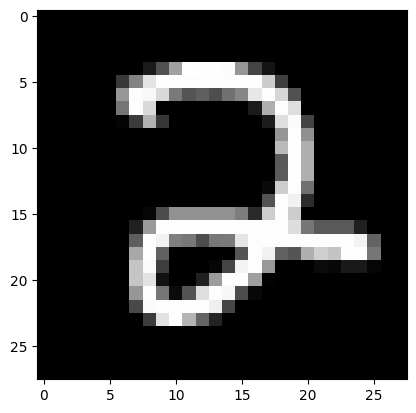

prediction: [6]
lable: 6


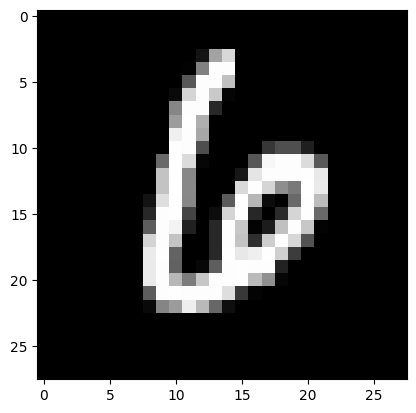

prediction: [4]
lable: 4


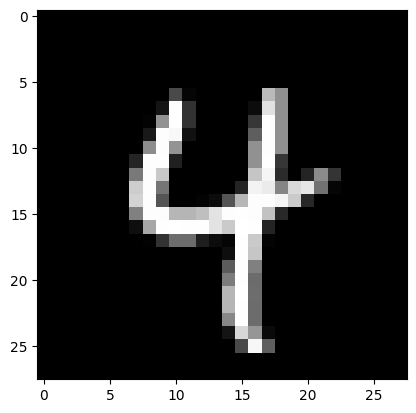

prediction: [8]
lable: 8


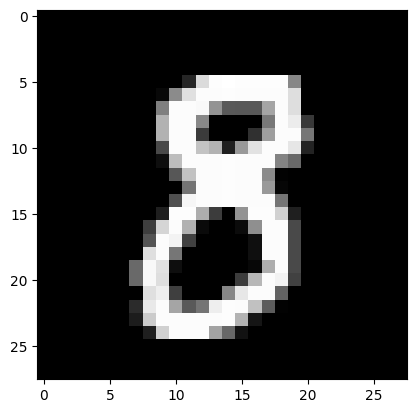

In [62]:
W_current = W
b_current = b
show_pred(0,X_train,Y_train, W_current, b_current)
show_pred(1,X_train,Y_train, W_current, b_current)
show_pred(2,X_train,Y_train, W_current, b_current)
show_pred(3,X_train,Y_train, W_current, b_current)

In [70]:
test_pred_Y = get_new_pred(X_test,W_current,b_current)
test_accuracy = get_accuracy(Y_test,test_pred_Y)
test_accuracy

0.943

prediction: [9]
lable: 9


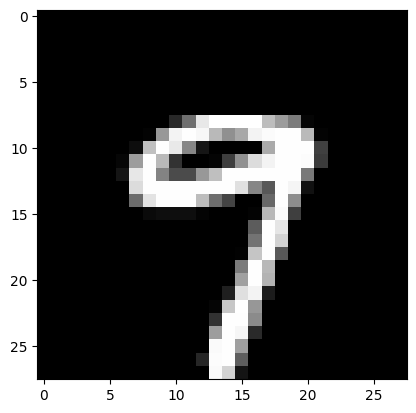

In [63]:
show_pred(3,X_test,Y_test, W_current, b_current)